# Steganography

## Module Import

In [2]:
import wave
import numpy as np
import os
from pydub import AudioSegment

## Audio Conversion Function

Now we define a function that check the imported cover audio if it has '.wav' extension. If not, we convert it using PyDub.

In [3]:
def convertToWav(inputFile):
    if not os.path.exists(inputFile):
        print(f"Error: The input file '{inputFile}' does not exist.")
        return None
    _, ext = os.path.splitext(inputFile)
    if ext.lower() == '.wav':
        print(f"The file '{inputFile}' is already in WAV format.")
        return inputFile
    outputFile = os.path.splitext(inputFile)[0] + '.wav'
    try:
        audio = AudioSegment.from_file(inputFile)
        audio.export(outputFile, format="wav")
        print(f"Audio successfully converted to WAV format: {outputFile}")
        return outputFile
    except Exception as e:
        print(f"An error occurred during conversion: {e}")
        return None

We do the same function on the message audio.

## Capacity Checking Function

As cover audio can hold only so much of message audio, it is crucial to check for overflow prior performing steganography.

In [ ]:
def calculateAudioCapacity(filePath):
    with wave.open(filePath, 'rb') as wf:
        # Extract properties
        channels = wf.getnchannels()          # Number of channels
        sampleWidth = wf.getsampwidth()       # Bytes per sample
        frameRate = wf.getframerate()         # Sampling rate (samples per second)
        frames = wf.getnframes()             # Total frames
        bitDepth = sampleWidth * 8           # Bits per sample
        duration = frames / frameRate       # Duration in seconds
        # Calculate total number of samples
        totalSamples = frames * channels  # Each channel counts as a sample

        # Capacity is 1 bit per sample for LSB steganography
        capacityBits = totalSamples          # Total bits available for LSB

        print(f"Cover Audio Properties:")
        print(f"  Duration: {duration:.2f} seconds")
        print(f"  Channels: {channels}")
        print(f"  Bit Depth: {bitDepth} bits")
        print(f"  Frame Rate: {frameRate} Hz")
        print(f"  Total Samples: {totalSamples}")
        print(f"  Capacity for LSB Steganography: {capacityBits} bits")

        return capacityBits, duration


def calculateMessageSize(filePath):
    with wave.open(filePath, 'rb') as wf:
        # Extract properties
        channels = wf.getnchannels()
        sampleWidth = wf.getsampwidth()
        frameRate = wf.getframerate()
        frames = wf.getnframes()
        bitDepth = sample_width * 8           # Bits per sample
        duration = frames / frameRate       # Duration in seconds

        # Total number of samples in the message audio
        totalSamples = frames * channels

        # Total bits in the message
        totalBits = totalSamples * bitDepth

        print(f"Message Audio Properties:")
        print(f"  Duration: {duration:.2f} seconds")
        print(f"  Channels: {channels}")
        print(f"  Bit Depth: {bitDepth} bits")
        print(f"  Frame Rate: {frameRate} Hz")
        print(f"  Total Samples: {totalSamples}")
        print(f"  Message Size: {totalBits} bits")

        return totalBits


def checkCapacity(coverAudioPath, messageAudioPath):
    if not os.path.exists(coverAudioPath):
        print(f"Error: Cover audio file '{coverAudioPath}' not found.")
        return False
    if not os.path.exists(messageAudioPath):
        print(f"Error: Message audio file '{messageAudioPath}' not found.")
        return False

    # Calculate cover audio capacity
    coverCapacity, coverDuration = calculateAudioCapacity(coverAudioPath)

    # Calculate message audio size
    messageSize = calculateMessageSize(messageAudioPath)

    # Compare capacities
    if coverCapacity >= messagSize:
        print(f"\nSuccess: The message audio can fit into the cover audio!")
        print(f"  Cover Audio Capacity: {coverCapacity} bits")
        print(f"  Message Audio Size: {messageSize} bits")
        return True
    else:
        print(f"\nError: The message audio is too large to fit into the cover audio.")
        print(f"  Cover Audio Capacity: {coverCapacity} bits")
        print(f"  Message Audio Size: {messageSize} bits")
        print(f"  You would need a larger cover audio or a smaller message audio.")
        return False

## Audio to Binary Conversion Function

Now, we define a function that will convert both the cover and message audio as per their metadata.

In [8]:
def audioToBinary(audioPath):
    with wave.open(audioPath, 'rb') as wf:
        channels = wf.getnchannels()
        sampleWidth = wf.getsampwidth()
        frames = wf.getnframes()

        # Read raw frames and convert to integers
        rawFrames = wf.readframes(frames)
        # Maximum integer based on sample width
        maxInt = 2 ** (sampleWidth * 8)

        # Convert raw bytes to integers, taking sample width into account
        samples = [
            int.from_bytes(rawFrames[i:i+sampleWidth],
                           'little', signed=(sampleWidth > 1))
            for i in range(0, len(rawFrames), sampleWidth)
        ]

        # Convert each sample to binary
        binaryStream = ''.join(
            f'{(sample + maxInt) % maxInt:0{sampleWidth * 8}b}' for sample in samples)
        return binaryStream, channels

## Channel-wise LSB Steganography Function

Now, we define a function that will perform channel-wise lsb steganography, that is, encode the message audio in the cover audio.

In [9]:
def encodeLSB(coverAudioPath, messageAudioPath, outputPath):
    # Load the cover audio and message audio
    with wave.open(coverAudioPath, 'rb') as coverWav, wave.open(messageAudioPath, 'rb') as messageWav:
        # Cover audio properties
        coverChannels = coverWav.getnchannels()
        coverSampleWidth = coverWav.getsampwidth()
        coverFrameRate = coverWav.getframerate()
        coverFrames = coverWav.getnframes()
        # Message audio binary stream
        messageBinary, messageChannels = audioToBinary(messageAudioPath)
        # Ensure the message can fit into the cover
        totalCoverSamples = coverFrames * coverChannels
        if len(messageBinary) > totalCoverSamples:
            raise ValueError(
                "Message audio is too large to fit into the cover audio.")
        # Read cover audio frames
        rawCoverFrames = coverWav.readframes(coverFrames)
        coverSamples = [
            int.from_bytes(
                rawCoverFrames[i:i+coverSampleWidth], 'little', signed=(coverSampleWidth > 1))
            for i in range(0, len(rawCoverFrames), coverSampleWidth)
        ]
        # Encode the message into the LSB of cover audio
        messageIndex = 0
        # Maximum integer based on sample width
        maxInt = 2 ** (coverSampleWidth * 8)
        for i in range(len(coverSamples)):
            if messageIndex < len(messageBinary):
                # Modify the LSB of the cover sample
                coverSamples[i] = (coverSamples[i] & ~1) | int(
                    messageBinary[messageIndex])
                messageIndex += 1
        # Convert back to bytes
        stegoFrames = b''.join(
            ((sample + maxInt) % maxInt).to_bytes(coverSampleWidth,
                                                  'little', signed=(coverSampleWidth > 1))
            for sample in coverSamples
        )
        # Write the stego audio to a new WAV file
        with wave.open(outputPath, 'wb') as stegoWav:
            stegoWav.setnchannels(coverChannels)
            stegoWav.setsampwidth(coverSampleWidth)
            stegoWav.setframerate(coverFrameRate)
            stegoWav.writeframes(stegoFrames)

    print(f"Message audio has been encoded into the cover audio and saved to {
          outputPath}")

Now, we define a function that will decrypt the stego audio and retrieve the message audio. However, in decryption we have to specify the bit depth and channels in the message audio, as the code will not work otherwise. It is assumed that a mono audio signal with 16 bit depth is the message signal.

In [10]:
def decodeLSB(stegoAudioPath, messageAudioPath, messageBitDepth=16, messageChannels=1):
    with wave.open(stego_audio_path, 'rb') as stegoWav:
        # Extract stego audio properties
        stegoChannels = stegoWav.getnchannels()
        stegoSampleWidth = stegoWav.getsampwidth()
        stegoFrameRate = stegoWav.getframerate()
        stegoFrames = stegoWav.getnframes()
        # Read all samples from the stego audio
        rawStegoFrames = stegoWav.readframes(stegoFrames)
        # Maximum integer based on sample width
        maxInt = 2 ** (stegoSampleWidth * 8)
        # Extract samples as integers
        stegoSamples = [
            int.from_bytes(
                rawStegoFrames[i:i+stegoSampleWidth], 'little', signed=(stegoSampleWidth > 1))
            for i in range(0, len(rawStegoFrames), stegoSampleWidth)
        ]
        # Extract LSBs from stego samples
        binaryStream = ''.join(str(sample & 1) for sample in stegoSamples)
        # Reconstruct message samples from binary stream
        messageSamples = [
            int(binaryStream[i:i+messageBitDepth], 2) -
            (2 ** (messageBitDepth - 1))
            for i in range(0, len(binaryStream), messageBitDepth)
            if i + messageBitDepth <= len(binaryStream)
        ]
        # Adjust for multi-channel message audio
        messageFrames = len(messageSamples) // message_channels
        messageSamples = messageSamples[:messageFrames * messageChannels]
        # Write the reconstructed message audio to a new file
        with wave.open(message_audio_path, 'wb') as messageWav:
            messageSampleWidth = messageBitDepth // 8  # Convert bit depth to bytes
            messageWav.setnchannels(messageChannels)
            messageWav.setsampwidth(messageSampleWidth)
            messageWav.setframerate(stegoFrameRate)
            messageWav.writeframes(
                b''.join(
                    (sample + maxInt // 2).to_bytes(messageSampleWidth,
                                                    'little', signed=(messageSampleWidth > 1))
                    for sample in messageSamples
                )
            )

    print(f"Hidden message audio has been decoded and saved to {
          messageAudioPath}")

# Experiment Section

In [1]:
import qiskit
import random
import numpy
import math
import matplotlib
import re
import qiskit_aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import circuit_drawer, plot_histogram
qiskit.__version__

: 

In [55]:
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(4, name='cr')

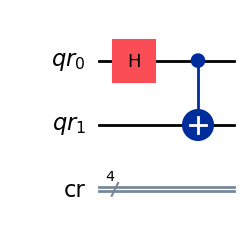

In [56]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.h(qr[0])
singlet.cx(qr[0], qr[1])
singlet.draw(output='mpl')

In [57]:
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0], cr[0])

measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.s(qr[0])
measureA2.h(qr[0])
measureA2.t(qr[0])
measureA2.measure(qr[0], cr[0])

measureA3 = QuantumCircuit(qr, cr, name='measureA3')
measureA3.measure(qr[0], cr[0])

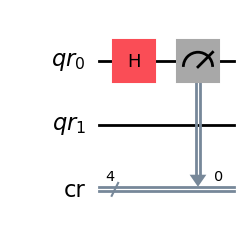

In [58]:
measureA1.draw(output='mpl')

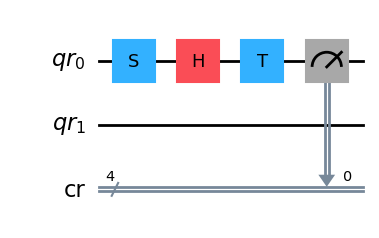

In [59]:

measureA2.draw(output='mpl')

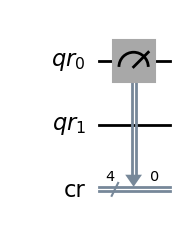

In [60]:
measureA3.draw(output='mpl')

In [61]:
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.measure(qr[1], cr[1])

measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.h(qr[1])
measureB2.t(qr[1])
measureB2.measure(qr[1], cr[1])

measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1], cr[1])

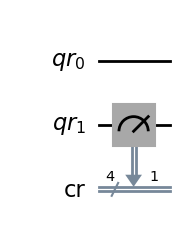

In [62]:
measureB1.draw(output='mpl')

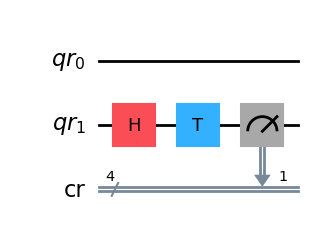

In [63]:
measureB2.draw(output='mpl')

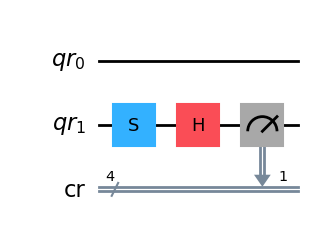

In [64]:
measureB3.draw(output='mpl')

In [65]:
aliceMeasurements = [measureA1, measureA2, measureA3]
bobMeasurements = [measureB1, measureB2, measureB3]

In [66]:
numberOfSinglets = 500

In [67]:
aliceMeasurementChoices = [random.randint(
    1, 3) for i in range(numberOfSinglets)]
bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)]

circuits = []
for i in range(numberOfSinglets):
    circuitName = singlet.compose(
        aliceMeasurements[aliceMeasurementChoices[i]-1])
    circuitName = circuitName.compose(
        bobMeasurements[bobMeasurementChoices[i]-1])
    circuits.append(circuitName)

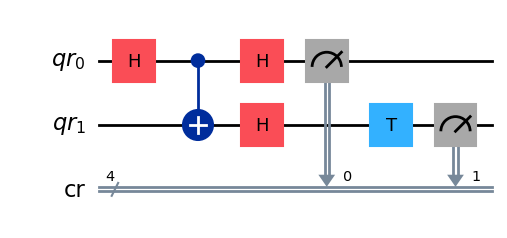

In [68]:
circuits[50].draw(output='mpl')

In [ ]:
backend = Aer.get_backend('qasm_simulator')
simulationCircuit = transpile(circuits, backend)
job = backend.run(simulationCircuit, shots=1)
result = job.result()
result.get_counts(circuits[4])

NameError: name 'Aer' is not defined

In [70]:
abPatterns = [re.compile('..00$'), re.compile(
    '..01$'), re.compile('..10$'), re.compile('..11$')]

In [74]:
aliceResults = []
bobResults = []
for i in range(numberOfSinglets):
    counts = result.get_counts(circuits[i])
    print(counts)

{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'0010': 1}
{'00

c:\Users\skywalker\miniconda3\Lib\site-packages\qiskit\result\result.py:379: UserWarning: Result object contained multiple results matching name "singlet", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(
